In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
import openfermion

import numpy as np

import pennylane as qml
from pennylane import expval


In [2]:
#create our molecule using pennylane's qchem tools.
name = 'h2'
geometry = 'molecules/h2.xyz'
charge = 0
multiplicity = 1
basis_set = 'sto-3g'

hamiltonian, nr_qubits = qml.qchem.generate_hamiltonian(
    name,
    geometry,
    charge,
    multiplicity,
    basis_set,
    n_active_electrons=2,
    n_active_orbitals=2,
    mapping='jordan_wigner'
)

print('Number of qubits = ', nr_qubits)

Number of qubits =  4


In [3]:
dev = qml.device("default.qubit", wires=4)

def ansatz(params, wires=[0,1,2,3]):
    for i in wires:
        qml.RY(params[i], wires=wires[i])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.CNOT(wires=[wires[1], wires[2]])
    for i in wires:
        qml.RY(params[i+4], wires=wires[i])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.CNOT(wires=[wires[1], wires[2]])

In [4]:
#create cost function using pennylane tools
cost = qml.VQECost(ansatz, hamiltonian, dev)

Number of VQE runs

In [5]:
k_runs = 25

In [6]:
step_size = 0.5
max_iterations = 150

In [7]:
param_trials = []

for i in range(k_runs):
    params = np.random.uniform(low=0, high=2*np.pi, size=12).tolist()
    param_trials.append(params)

Here, we don't terminate based on energy improvement but run a fixed number of steps (50 in this case). 

In [8]:
# Lists to store energy histories for all the VQE runs
energy_history_QNG = []

opt = qml.QNGOptimizer(0.05)

for k in range(k_runs):

    # Energy history for a single VQE run
    energy_history_single_run_QNG = []

    # initialize parameters based on param_trials created above
    initial_params = param_trials[k]

    params = initial_params
    prev_energy = cost(params)
    energy_history_single_run_QNG.append(prev_energy)

    for n in range(max_iterations):

        params = opt.step(cost, params)
        energy = cost(params)

        conv = np.abs(energy - prev_energy)

        prev_energy = energy
        energy_history_single_run_QNG.append(prev_energy)

    if (k) % 5 == 0:
        print('Finished run #{}'.format(k))

    energy_history_single_run_QNG = np.array(energy_history_single_run_QNG)

    energy_history_QNG.append(energy_history_single_run_QNG)

Finished run #0
Finished run #5
Finished run #10
Finished run #15
Finished run #20


In [9]:
energy_history_vanilla = []

opt = qml.GradientDescentOptimizer(0.05)

for k in range(k_runs):

    # Energy history for a single VQE run
    energy_history_single_run_vanilla = []

    # initialize parameters based on param_trials created above
    initial_params = param_trials[k]

    params = initial_params
    prev_energy = cost(params)
    energy_history_single_run_vanilla.append(prev_energy)

    for n in range(max_iterations):

        params = opt.step(cost, params)
        energy = cost(params)
    
        prev_energy = energy
        energy_history_single_run_vanilla.append(prev_energy)

    if (k) % 5 == 0:
        print('Finished run #{}'.format(k))

    energy_history_single_run_vanilla = np.array(energy_history_single_run_vanilla)

    energy_history_vanilla.append(energy_history_single_run_vanilla)


Finished run #0
Finished run #5
Finished run #10
Finished run #15
Finished run #20


In [10]:
# Lists to store energy histories for all the VQE runs
energy_history_QNG_diag = []

opt = qml.QNGOptimizer(0.05, diag_approx=True)

for k in range(k_runs):

    # Energy history for a single VQE run
    energy_history_single_run_QNG_diag = []

    # initialize parameters based on param_trials created above
    initial_params = param_trials[k]

    params = initial_params
    prev_energy = cost(params)
    energy_history_single_run_QNG_diag.append(prev_energy)

    for n in range(max_iterations):

        params = opt.step(cost, params)
        energy = cost(params)

        conv = np.abs(energy - prev_energy)

        prev_energy = energy
        energy_history_single_run_QNG_diag.append(prev_energy)

    if (k) % 5 == 0:
        print('Finished run #{}'.format(k))

    energy_history_single_run_QNG_diag = np.array(energy_history_single_run_QNG_diag)

    energy_history_QNG_diag.append(energy_history_single_run_QNG_diag)


Finished run #0
Finished run #5
Finished run #10
Finished run #15
Finished run #20


QNG


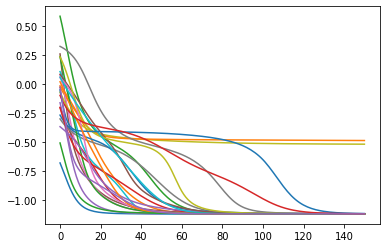

QNG diag. approx.


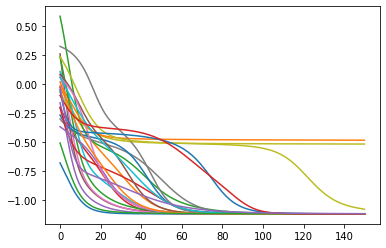

vanilla


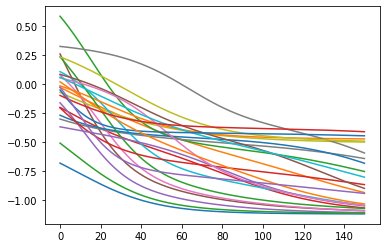

In [11]:
for i in range(k_runs):
    plt.plot(energy_history_QNG[i])

print("QNG")
plt.show()


for i in range(k_runs):
    plt.plot(energy_history_QNG_diag[i])

print("QNG diag. approx.")
plt.show()


for i in range(k_runs):
    plt.plot(energy_history_vanilla[i])

print("vanilla")
plt.show()


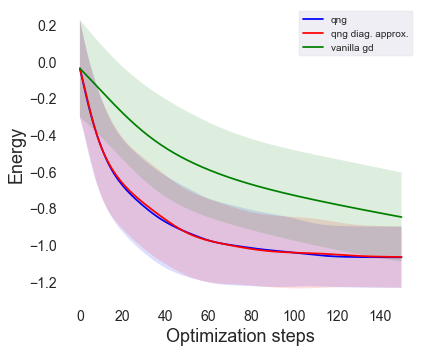

In [13]:
%matplotlib inline
plt.style.use("seaborn")
fig = plt.figure(figsize=(6, 5))

ax = plt.axes()
ax.set_facecolor("white")

'''    PLOTTING STD ---- QNG   '''


#needs to be an array for .mean() and .std() to work for some reason
energy_hist_QNG = np.asarray(energy_history_QNG)

#x values (optimization steps)
x = np.arange(max_iterations+1)

#calc standard dev. and mean
std_qng = energy_hist_QNG.std(axis=0)
mean_qng = energy_hist_QNG.mean(axis=0)

#plot mean for reference
plt.plot(mean_qng, color='blue', label='qng')

#plot x values, and fill to +- standard dev
plt.fill_between(x, mean_qng-std_qng, mean_qng+std_qng, facecolor='blue', alpha=0.13)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel("Energy", fontsize=18)
plt.xlabel("Optimization steps", fontsize=18)

plt.tight_layout()


'''    PLOTTING STD -- VANILLA GD  '''


energy_hist_vanilla = np.asarray(energy_history_vanilla)


x = np.arange(max_iterations+1)


std_vanilla = energy_hist_vanilla.std(axis=0)
mean_vanilla = energy_hist_vanilla.mean(axis=0)


plt.plot(mean_vanilla, color='green', label='vanilla gd')


plt.fill_between(x, mean_vanilla-std_vanilla, mean_vanilla+std_vanilla, facecolor='green', alpha=0.13,)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel("Energy", fontsize=18)
plt.xlabel("Optimization steps", fontsize=18)


plt.tight_layout()
ax. legend(loc='upper right', frameon=True)
plt.show()


In [8]:
opt = qml.QNGOptimizer(0.05, diag_approx=True)
type(opt)


pennylane.optimize.qng.QNGOptimizer